# Feature selection

Libraries imported

In [10]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.inspection import permutation_importance

Use DVC to get data with required dropped loading levels, then load the .csv files here.

In [11]:
X_test=pd.read_csv('Data/processed/X_test.csv')
y_test=pd.read_csv('Data/processed/y_test.csv')
X_train=pd.read_csv('Data/processed/X_train.csv')
y_train=pd.read_csv('Data/processed/y_train.csv')
dataset=pd.read_csv('Data/raw/dataset.csv')

### Feature correlation

Text(0.5, 1.0, 'Feature correlation, Pearson')

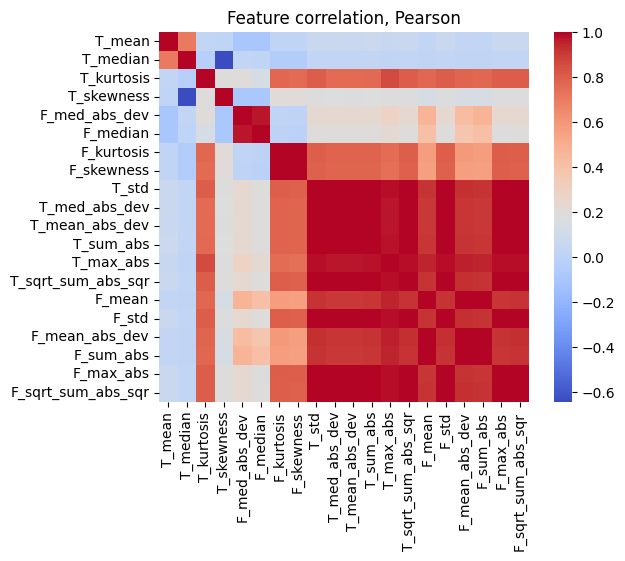

In [12]:
fig, ax=plt.subplots()
corr=dataset.drop(columns=['Loading','Label']).corr("pearson")
sns.heatmap(corr,mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.color_palette("coolwarm", as_cmap=True),
            square=True, ax=ax)
ax.set_title('Feature correlation, Pearson')

### SVC Model

In [13]:
param_grid={
"SVC__C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
"SVC__gamma": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
pipe=Pipeline(steps=[('scaler', StandardScaler()),
                             ('SVC', SVC(probability=True,decision_function_shape='ovr'))])
clf=GridSearchCV(estimator=pipe,
                     param_grid=param_grid,
                     cv=5,
                     scoring='neg_log_loss',
                     return_train_score=True,
                     verbose=1,
                     n_jobs=4)
clf.fit(X_train,np.ravel(y_train))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC', SVC(probability=True))]),
             n_jobs=4,
             param_grid={'SVC__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                    1000],
                         'SVC__gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                                        100, 1000]},
             return_train_score=True, scoring='neg_log_loss', verbose=1)

Best parameters

In [14]:
svc_model=clf.best_estimator_
clf.best_params_

{'SVC__C': 100, 'SVC__gamma': 0.1}

Metrics

In [15]:
svc_f1=f1_score(y_test,svc_model.predict(X_test),average='macro')
svc_log_loss=log_loss(y_test,svc_model.predict_proba(X_test))
print(f"SVC model F1 = {svc_f1}\nSVC model log-loss = {svc_log_loss}")

SVC model F1 = 0.996851749369735
SVC model log-loss = 0.02418396747597024


### GBC Model

In [16]:
gbc_param_grid={
    "GBC__n_estimators": [200, 500],
    "GBC__max_depth": [6,9],
    "GBC__learning_rate": [0.1],
    "GBC__subsample": [0.3],
    "GBC__validation_fraction": [0.2],
    "GBC__tol": [0.01, 0.1],
    "GBC__n_iter_no_change": [50],
    "GBC__random_state": [0],
}
gbc_pipe=Pipeline(steps=[('scaler', StandardScaler()),
                             ('GBC', GradientBoostingClassifier())])
clf_gbc=GridSearchCV(estimator=gbc_pipe,
                     param_grid=gbc_param_grid,
                     cv=5,
                     scoring='neg_log_loss',
                     return_train_score=True,
                     verbose=1,
                     n_jobs=4)
clf_gbc.fit(X_train,np.ravel(y_train))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('GBC', GradientBoostingClassifier())]),
             n_jobs=4,
             param_grid={'GBC__learning_rate': [0.1], 'GBC__max_depth': [6, 9],
                         'GBC__n_estimators': [200, 500],
                         'GBC__n_iter_no_change': [50],
                         'GBC__random_state': [0], 'GBC__subsample': [0.3],
                         'GBC__tol': [0.01, 0.1],
                         'GBC__validation_fraction': [0.2]},
             return_train_score=True, scoring='neg_log_loss', verbose=1)

In [17]:
gbc_model=clf_gbc.best_estimator_
clf_gbc.best_params_

{'GBC__learning_rate': 0.1,
 'GBC__max_depth': 6,
 'GBC__n_estimators': 200,
 'GBC__n_iter_no_change': 50,
 'GBC__random_state': 0,
 'GBC__subsample': 0.3,
 'GBC__tol': 0.01,
 'GBC__validation_fraction': 0.2}

Metrics

In [18]:
gbc_f1=f1_score(y_test,gbc_model.predict(X_test),average='macro')
gbc_log_loss=log_loss(y_test,gbc_model.predict_proba(X_test))
print(f"GBC model F1 = {gbc_f1}\nGBC model log-loss = {gbc_log_loss}")

GBC model F1 = 0.9968116487792631
GBC model log-loss = 0.019031246300711825


### MLP Model

In [19]:
mlp_model=keras.Sequential([
    layers.BatchNormalization(name='Layer_1',input_shape=[np.shape(X_train)[1]]),
    layers.Dense(name='Layer_2',units=128,activation='swish',kernel_regularizer=regularizers.L2(0.01)),
    layers.Dense(name='Layer_3',units=128,activation='selu',kernel_regularizer=regularizers.L2(0.001)),
    layers.BatchNormalization(name='Layer_4',),
    layers.Dropout(0.3,name='Layer_5'),
    layers.Dense(name='Layer_6',units=128,activation='swish',kernel_regularizer=regularizers.L2(0.001)),
    layers.Dense(name='Output_layer',units=5,activation='softmax'),])
mlp_model.compile(
    
    optimizer=keras.optimizers.Adam(1e-3),
    loss='SparseCategoricalCrossentropy',
    metrics=['SparseCategoricalAccuracy',
             'SparseCategoricalCrossentropy'],
    jit_compile=True
)
#training with early stoppings defined
early_stoppings=keras.callbacks.EarlyStopping(patience=10,
min_delta=0.001,restore_best_weights=True,start_from_epoch=25)
history=mlp_model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=16,
                  epochs=128,
                  callbacks=[early_stoppings],
                  verbose=1,
                  use_multiprocessing=True,
                  )

Epoch 1/128
80/80 [==============================] - 3s 8ms/step - loss: 1.7205 - sparse_categorical_accuracy: 0.5289 - sparse_categorical_crossentropy: 1.1320 - val_loss: 40.5374 - val_sparse_categorical_accuracy: 0.2156 - val_sparse_categorical_crossentropy: 39.9631
Epoch 2/128
80/80 [==============================] - 0s 2ms/step - loss: 1.3921 - sparse_categorical_accuracy: 0.6484 - sparse_categorical_crossentropy: 0.8311 - val_loss: 38.9445 - val_sparse_categorical_accuracy: 0.2156 - val_sparse_categorical_crossentropy: 38.3961
Epoch 3/128
80/80 [==============================] - 0s 2ms/step - loss: 1.3212 - sparse_categorical_accuracy: 0.6727 - sparse_categorical_crossentropy: 0.7832 - val_loss: 25.8345 - val_sparse_categorical_accuracy: 0.2156 - val_sparse_categorical_crossentropy: 25.3069
Epoch 4/128
80/80 [==============================] - 0s 2ms/step - loss: 1.1418 - sparse_categorical_accuracy: 0.7422 - sparse_categorical_crossentropy: 0.6237 - val_loss: 15.7116 - val_sparse_

Metrics

In [20]:
# f1 score
mlp_y_hat=mlp_model.predict(X_test)
dl_y_hat=np.argmax(mlp_y_hat,axis=1)
dl_f1=f1_score(y_test,dl_y_hat,average='macro')
dl_log_loss=log_loss(y_test,mlp_model(X_test))
print(f"MLP model F1 = {dl_f1}\nMLP model log-loss = {dl_log_loss}")

10/10 [==============================] - 0s 2ms/step
MLP model F1 = 0.9460308872241916
MLP model log-loss = 0.16558638918300267


## Permutation importance

### SVC

In [21]:
svc_perm = PermutationImportance(svc_model, random_state=0).fit(X_test, np.ravel(y_test))
eli5.show_weights(svc_perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3212 ± 0.0450,T_kurtosis
0.2756 ± 0.0294,T_max_abs
0.2594 ± 0.0660,F_skewness
0.2269 ± 0.0196,F_kurtosis
0.1856 ± 0.0297,F_mean_abs_dev
0.1775 ± 0.0165,F_sum_abs
0.1756 ± 0.0302,F_mean
0.1750 ± 0.0259,T_med_abs_dev
0.1737 ± 0.0436,T_mean
0.1650 ± 0.0458,T_mean_abs_dev


### GBC

In [22]:
gbc_perm = PermutationImportance(gbc_model, random_state=0).fit(X_test, np.ravel(y_test))
eli5.show_weights(gbc_perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2419 ± 0.0485,F_skewness
0.2144 ± 0.0270,T_kurtosis
0.0306 ± 0.0047,T_max_abs
0.0250 ± 0.0185,T_mean
0.0181 ± 0.0073,F_mean_abs_dev
0.0169 ± 0.0085,T_skewness
0.0169 ± 0.0075,T_mean_abs_dev
0.0062 ± 0.0040,F_kurtosis
0.0050 ± 0.0064,T_median
0.0044 ± 0.0050,F_mean


### MLP

In [23]:
def scorer(estimator,x,y):
    dl_y_hat=estimator.predict(x)
    dl_y_hat=np.argmax(dl_y_hat,axis=1)
    dl_f1=f1_score(y,dl_y_hat,average='macro')
    return dl_f1

In [24]:
r_multi = permutation_importance(mlp_model, X_test, y_test, n_repeats=30, random_state=0, scoring=scorer)

10/10 [==============================] - 0s 1ms/step


10/10 [==============================] - 0s 492us/step


In [25]:
mlp_perm=pd.DataFrame([X_test.columns,r_multi['importances_mean'],r_multi['importances_std']],index=['Feature','Permutation Importance','Std of importance'])
mlp_perm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Feature,T_mean,T_median,T_kurtosis,T_skewness,F_med_abs_dev,F_median,F_kurtosis,F_skewness,T_std,T_med_abs_dev,T_mean_abs_dev,T_sum_abs,T_max_abs,T_sqrt_sum_abs_sqr,F_mean,F_std,F_mean_abs_dev,F_sum_abs,F_max_abs,F_sqrt_sum_abs_sqr
Permutation Importance,0.08635,0.096209,0.345707,0.052457,0.01609,0.033969,0.104435,0.279682,0.24828,0.424041,0.433572,0.161777,0.635335,0.170221,0.250743,0.283055,0.274947,0.203509,0.278781,0.086973
Std of importance,0.011788,0.015344,0.02265,0.009797,0.006859,0.008754,0.016362,0.025703,0.024795,0.020679,0.022915,0.019186,0.027904,0.016873,0.018712,0.028352,0.018176,0.016788,0.027568,0.012747


## SHAP

### SVC



In [28]:
shap.initjs()
svc_explainer = shap.KernelExplainer(svc_model.predict_proba,shap.kmeans(X_train,5),seed=0)
svc_shap_values = svc_explainer.shap_values(X_test)
shap.force_plot(svc_explainer.expected_value[0], svc_shap_values[0], X_test)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/320 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

KeyboardInterrupt: 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


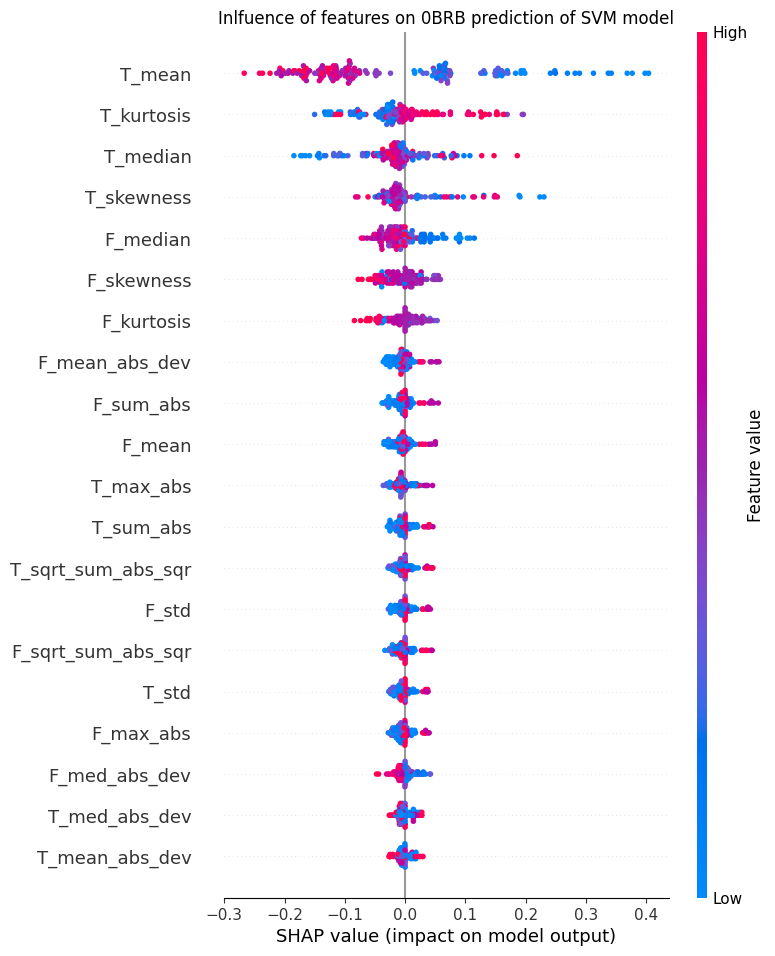

In [ ]:
shap.summary_plot(svc_shap_values[0], X_test, show=False)
plt.title('Inlfuence of features on 0BRB prediction of SVM model')
plt.show()

In [ ]:
shap.force_plot(svc_explainer.expected_value[0], svc_shap_values[0], X_test)

### GBC

In [ ]:
shap.initjs()
gbc_explainer = shap.KernelExplainer(gbc_model.predict_proba,shap.kmeans(X_train,20),seed=0)
gbc_shap_values = gbc_explainer.shap_values(X_test)
shap.force_plot(gbc_explainer.expected_value[0], gbc_shap_values[0], X_test)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/544 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


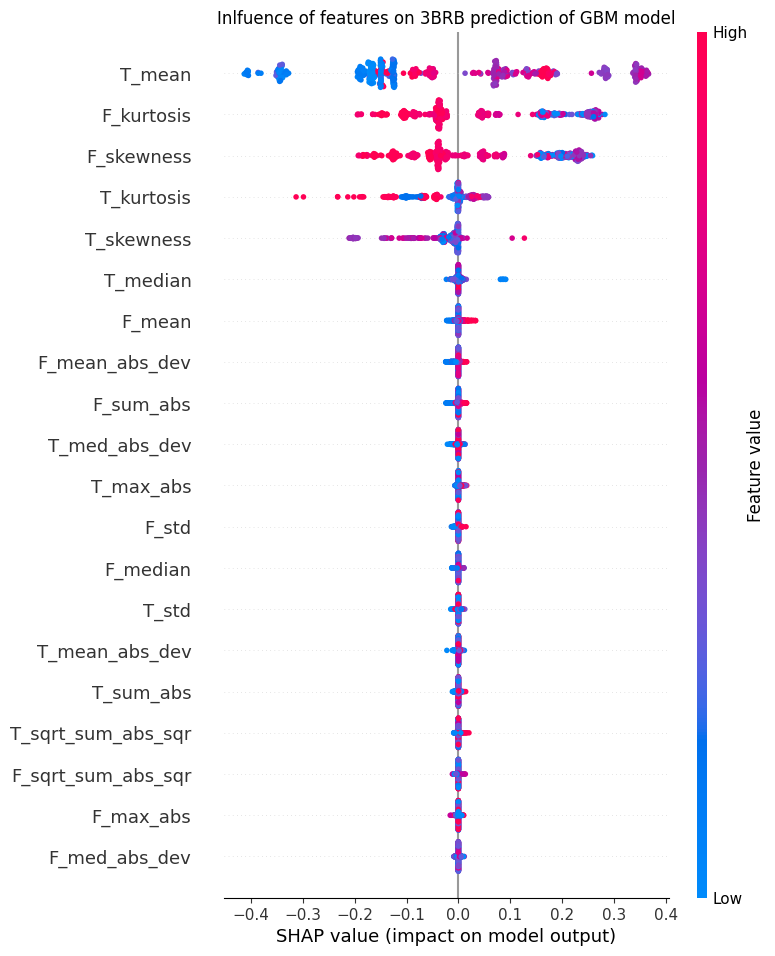

In [ ]:
shap.summary_plot(gbc_shap_values[3], X_test, show=False)
plt.title('Inlfuence of features on 3BRB prediction of GBM model')
plt.show()

#### MLP

In [ ]:
shap.initjs()
mlp_explainer = shap.KernelExplainer(mlp_model,shap.kmeans(X_train,20),seed=0)
mlp_shap_values = mlp_explainer.shap_values(X_test)
shap.force_plot(mlp_explainer.expected_value[0], mlp_shap_values[0], X_test)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


  0%|          | 0/160 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


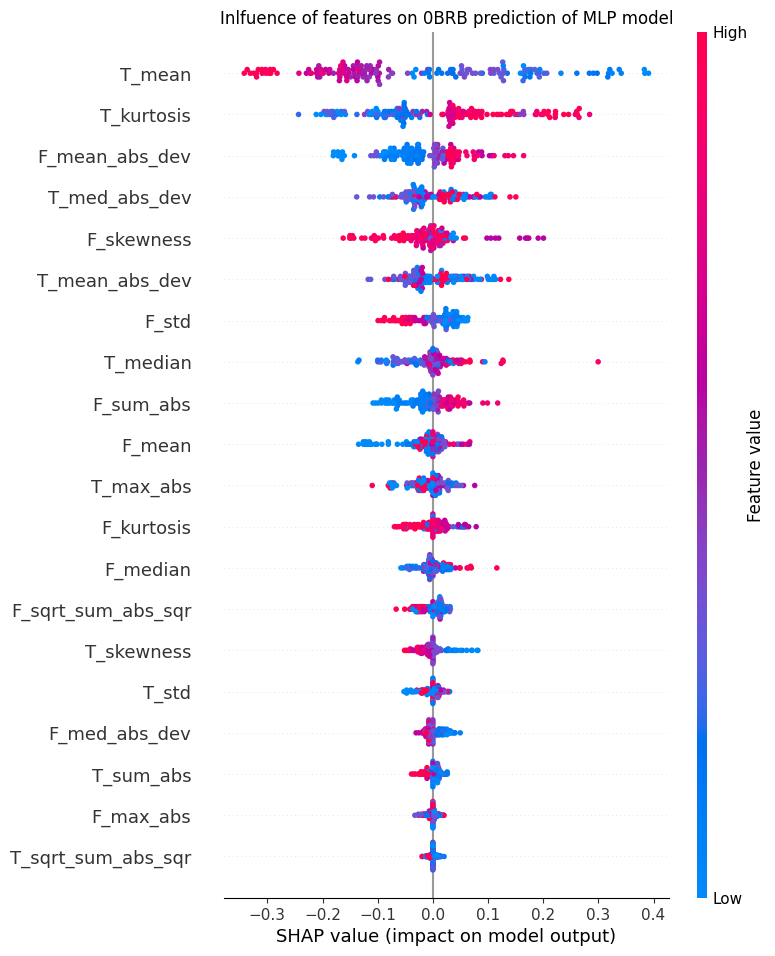

In [ ]:
shap.summary_plot(mlp_shap_values[0], X_test, show=False)
plt.title('Inlfuence of features on 0BRB prediction of MLP model')
plt.show()